<a href="https://colab.research.google.com/github/sankarvinayak/RL-assignments/blob/main/Tutorial_5_Deep_Q_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial 5 - DQN

Please follow this tutorial to understand the structure (code) of DQN algorithm.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding of the core concepts. Contact the TAs for further resources if needed.


In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gymnasium as gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [3]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''
env = gym.make('CartPole-v1')

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, _ , info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
0
----
(array([ 0.00539916, -0.04942269, -0.03425706,  0.0120981 ], dtype=float32), {})
----
1
----
[ 0.0044107   0.14617339 -0.0340151  -0.29119346]
1.0
False
{}
----


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [4]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

Recall why we use such a technique.

In [5]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [6]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [7]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(agent,n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):#modified added an argument to pass the agent

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
####################################
    scores=[]
####################################
    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ , _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
####################################
        scores.append(score) #modified added a python list which will keep track of the history of the score which can be later made use for plotting score
####################################
        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return True,scores


In [ ]:

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
_,eps_gree_scores=dqn(agent)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 100	Average Score: 41.51
Episode 200	Average Score: 141.16
Episode 300	Average Score: 96.10
Episode 400	Average Score: 22.85
Episode 500	Average Score: 108.70
Episode 600	Average Score: 116.44
Episode 700	Average Score: 44.41
Episode 800	Average Score: 133.07
Episode 900	Average Score: 145.13
Episode 1000	Average Score: 78.04
Episode 1100	Average Score: 131.68
Episode 1200	Average Score: 131.43
Episode 1300	Average Score: 170.25
Episode 1400	Average Score: 192.97
Episode 1401	Average Score: 195.12
Environment solved in 1401 episodes!	Average Score: 195.12
0:08:36.480454


### **Task 1a**  
Understand the core of the algorithm, follow the flow of data. Identify the exploration strategy used.
### **Task 1b**
Out of the two exploration strategies discussed in class ($ϵ$-greedy & Softmax). Implement the strategy that's not used here.
### **Task 1c**
How fast does the agent 'solve' the environment in terms of the number of episodes?
(Cartpole-v1 defines "solving" as getting average reward of 195.0 over 100 consecutive trials)

How 'well' does the agent learn? (reward plot?) The above two are some 'evaluation metrics' you can use to comment on the performance of an algorithm.

Please compare DQN (using $\epsilon$-greedy) with DQN (using softmax). Think along the lines of 'no. of episodes', 'reward plots', 'compute time', etc. and add a few comments.



#### **Submission Steps**

#### Task 1: Add a text cell with the answer.

#### Task 2: Add a code cell below task 1 solution and use 'Tutorial Agent Code' to build your new agent (with a different exploration strategy).

#### Task 3: Add a code cell below task 2 solution running both the agents to solve the CartPole v-1 environment and add a new text cell below it with your inferences.

## Task 1a

### The Deep Q netowork
The algorithm used here is theidea of deep Q netowkr in which a Deep neural netowk (in this case two hidden units os size 128 and 64) which is used to store the action value function of each state action pair so that the Q learning algorithm can be applied and eventually the netowkr will be ablue to update the policies and get a good(more accurate) action value out of the trained neurral netowrk for the function representation.

Based on the action value provided by the model. Given the state the network generate the value associated with each action and based which the exploration stratagy selects the action to perform next and it will be applied to the world and based on the action choosen the score will vary based on which the network performance can be evaluated

A replay buffer is maintained of size $10^5$ so that insted of sampling state and action close to one another each state,action,reward,nextstae,done is given. We sample one of this and try the model to predict accurately and based this idea we adjust the  

## Task 1b

softmax action

In [10]:
class SoftmaxAgent(TutorialAgent):
  def __init__(self, state_size, action_size, seed,temperature=1):
    super().__init__(state_size, action_size, seed)
    self.temperature = temperature
  def act(self,state,eps):
    state=torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values=self.qnetwork_local(state)
    self.qnetwork_local.train()
    prbs=F.softmax(action_values,dim=1).cpu().data.numpy().flatten()
    action=np.random.choice(np.arange(self.action_size),p=prbs/prbs.sum())
    return action


In [ ]:

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = SoftmaxAgent(state_size=state_shape,action_size = action_shape,seed = 0)

_,softmax_scores=dqn(agent)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 100	Average Score: 122.78
Episode 200	Average Score: 44.02
Episode 300	Average Score: 31.52
Episode 400	Average Score: 11.86
Episode 500	Average Score: 28.66
Episode 600	Average Score: 25.16
Episode 700	Average Score: 64.78
Episode 800	Average Score: 41.18
Episode 900	Average Score: 65.36
Episode 1000	Average Score: 108.57
Episode 1100	Average Score: 88.71
Episode 1200	Average Score: 66.31
Episode 1300	Average Score: 81.63
Episode 1400	Average Score: 54.21
Episode 1500	Average Score: 42.10
Episode 1600	Average Score: 83.35
Episode 1700	Average Score: 73.58
Episode 1800	Average Score: 77.36
Episode 1900	Average Score: 31.15
Episode 2000	Average Score: 125.04
Episode 2019	Average Score: 195.52
Environment solved in 2019 episodes!	Average Score: 195.52
0:07:52.312017


## Task 1c

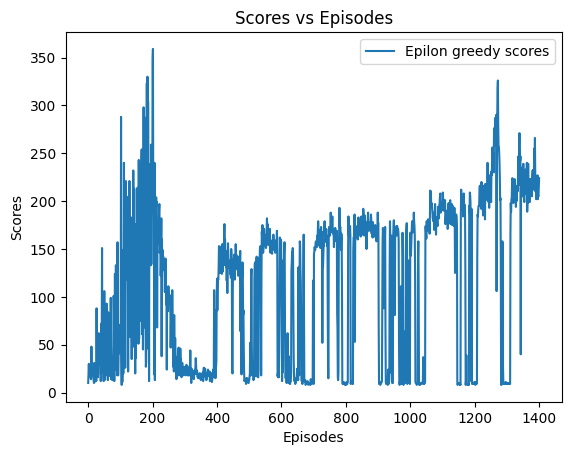

In [ ]:
from matplotlib import pyplot as plt
plt.plot(eps_gree_scores,label="Epilon greedy scores")
# plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()

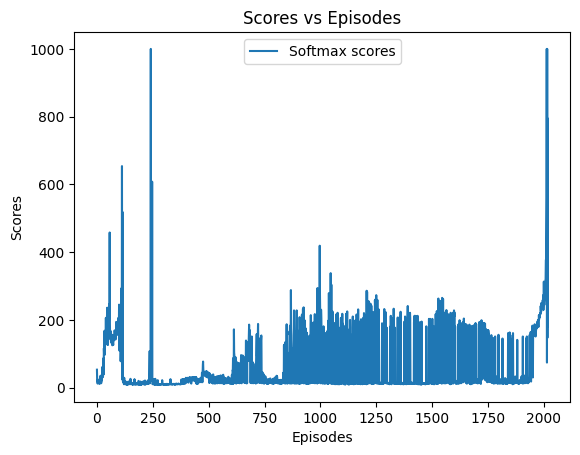

In [ ]:
from matplotlib import pyplot as plt
# plt.plot(eps_gree_scores,label="Epilon greedy scores")
plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()

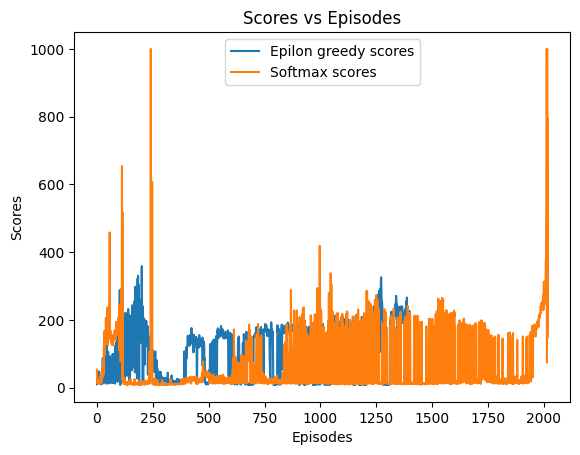

In [ ]:
from matplotlib import pyplot as plt
plt.plot(eps_gree_scores,label="Epilon greedy scores")
plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()

In [22]:

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
_,eps_gree_scores=dqn(agent)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 100	Average Score: 41.42
Episode 200	Average Score: 134.84
Episode 300	Average Score: 149.14
Episode 400	Average Score: 53.79
Episode 500	Average Score: 13.16
Episode 600	Average Score: 99.93
Episode 700	Average Score: 121.22
Episode 800	Average Score: 81.19
Episode 900	Average Score: 150.95
Episode 1000	Average Score: 56.82
Episode 1100	Average Score: 128.54
Episode 1200	Average Score: 107.16
Episode 1300	Average Score: 180.54
Episode 1400	Average Score: 170.84
Episode 1411	Average Score: 196.51
Environment solved in 1411 episodes!	Average Score: 196.51
0:08:25.670223


In [ ]:
from matplotlib import pyplot as plt
plt.plot(eps_gree_scores,label="Epilon greedy scores")
# plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()

In [23]:

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = SoftmaxAgent(state_size=state_shape,action_size = action_shape,seed = 0)

_,softmax_scores=dqn(agent)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 100	Average Score: 161.92
Episode 106	Average Score: 197.94
Environment solved in 106 episodes!	Average Score: 197.94
0:01:05.250034


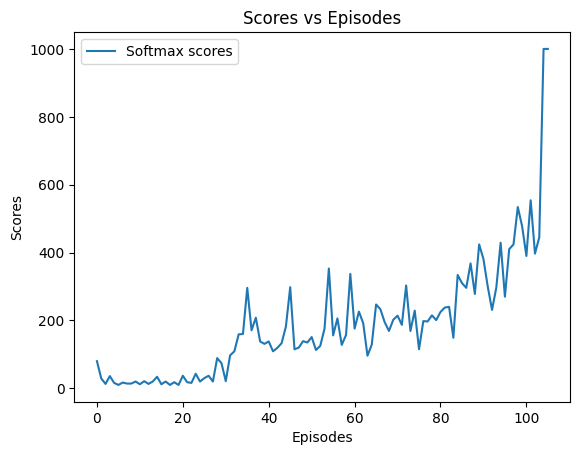

In [25]:
from matplotlib import pyplot as plt
# plt.plot(eps_gree_scores,label="Epilon greedy scores")
plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()

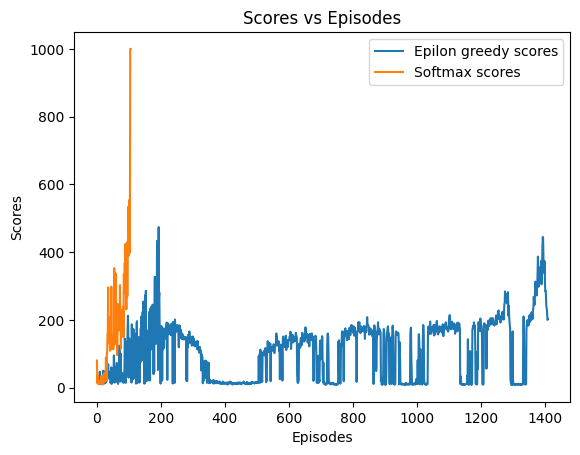

In [26]:
from matplotlib import pyplot as plt
plt.plot(eps_gree_scores,label="Epilon greedy scores")
plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()


Episode 100	Average Score: 45.59
Episode 200	Average Score: 125.58
Episode 300	Average Score: 115.31
Episode 400	Average Score: 47.87
Episode 500	Average Score: 123.48
Episode 600	Average Score: 59.76
Episode 700	Average Score: 133.69
Episode 800	Average Score: 42.74
Episode 900	Average Score: 140.23
Episode 1000	Average Score: 98.97
Episode 1100	Average Score: 98.03
Episode 1200	Average Score: 70.38
Episode 1300	Average Score: 169.42
Episode 1388	Average Score: 195.70
Environment solved in 1388 episodes!	Average Score: 195.70
0:08:00.013579


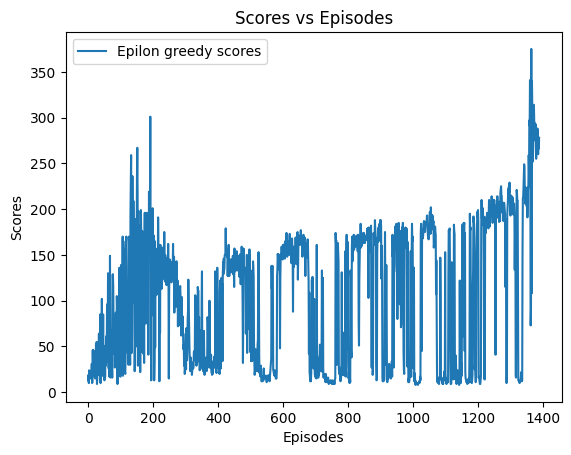

In [8]:

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
_,eps_gree_scores=dqn(agent)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)
from matplotlib import pyplot as plt
plt.plot(eps_gree_scores,label="Epilon greedy scores")
# plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()

Episode 100	Average Score: 124.94
Episode 200	Average Score: 71.28
Episode 300	Average Score: 12.28
Episode 400	Average Score: 20.76
Episode 500	Average Score: 9.48
Episode 600	Average Score: 19.91
Episode 700	Average Score: 16.53
Episode 800	Average Score: 175.70
Episode 803	Average Score: 204.24
Environment solved in 803 episodes!	Average Score: 204.24
0:02:34.586765


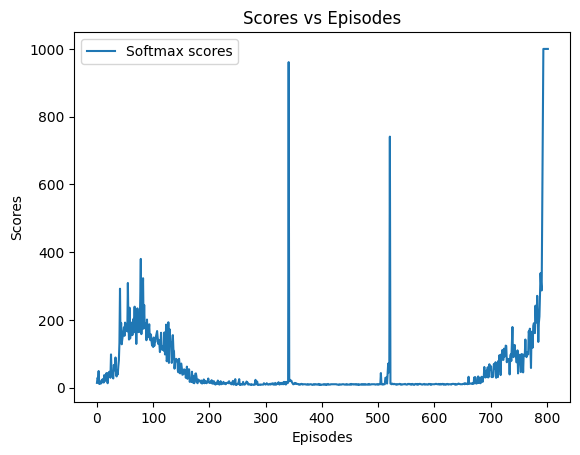

In [11]:

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = SoftmaxAgent(state_size=state_shape,action_size = action_shape,seed = 0)

_,softmax_scores=dqn(agent)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)
from matplotlib import pyplot as plt
# plt.plot(eps_gree_scores,label="Epilon greedy scores")
plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()

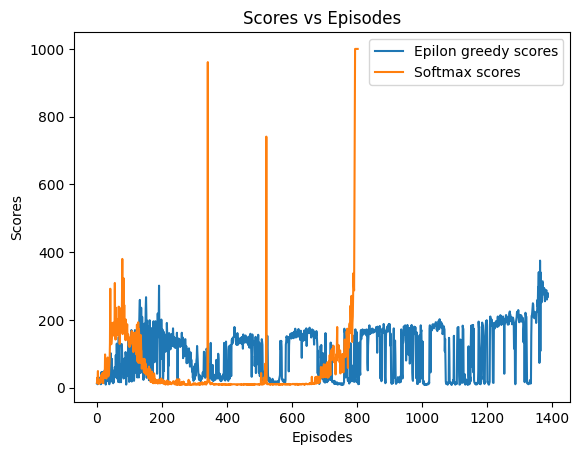

In [12]:
from matplotlib import pyplot as plt
plt.plot(eps_gree_scores,label="Epilon greedy scores")
plt.plot(softmax_scores,label="Softmax scores")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title("Scores vs Episodes")
plt.show()


From the above 3 different runs we can see that
- The maximum score achieved by soft max is generally mch more than that of epsilon greedy
- The time it take to train using softmax is comparable or less than that of epsilon greedy
- The dips in the score happens when the action is choosen randomly or the action to perform at that state is not yet properly learnined
- Epsilong greedy statagy have more varience in the score of consecutive episodes than that of softmax(ignoring the spikes)
- In all cases there is a initial state in which the scores increases which can be caused by the initialization and the exploration statagies used as the network has not yer explored all the posible action